# Query Language Model Evaluation

In [4]:
%load_ext autoreload
%autoreload 2
import json
import sys
import os
import pickle
import logging
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 1000)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


from tqdm.notebook import tqdm
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tqdm.pandas()

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from evaluation import *
from preprocessing import Corpus, BasicPreprocessing, BigramPreprocessor, SpacyPreprocessor, StopWordPreprocessor
from retrieval_algorithms import QueryLMRetrievalAlgorithm

In [5]:
def create_grid(scales):
    return [round(j*10**i,5) for i in scales for j in range(1,10)]

#### Load corpus using different preprocessing pipelines

In [6]:
base_file =  "../../data/kit_expert_2019_all_papers.csv"

p = [BasicPreprocessing(), StopWordPreprocessor()]
papers_basic = Corpus(base_file, p)

p = [BasicPreprocessing(), StopWordPreprocessor(), SpacyPreprocessor(lemmatization="all")]
papers_basic_lemmatization_all = Corpus(base_file, p, load_from_cache=True, n_jobs=16)

p = [BasicPreprocessing(), StopWordPreprocessor(), SpacyPreprocessor(lemmatization="nouns")]
papers_basic_lemmatization_nouns = Corpus(base_file, p, load_from_cache=True, n_jobs=16)

INFO:preprocessing.pipeline:Start preprocessing pipeline "basic_NoStopWords" for file ../../data/kit_expert_2019_all_papers.csv.
INFO:preprocessing.pipeline:Loaded cached preprocessed corpus from ../../data/kit_expert_2019_all_papers_basic_NoStopWords
INFO:preprocessing.pipeline:Start preprocessing pipeline "basic_NoStopWords_spacy_lemmatization_all" for file ../../data/kit_expert_2019_all_papers.csv.
INFO:preprocessing.pipeline:Loaded cached preprocessed corpus from ../../data/kit_expert_2019_all_papers_basic_NoStopWords_spacy_lemmatization_all
INFO:preprocessing.pipeline:Start preprocessing pipeline "basic_NoStopWords_spacy_lemmatization_nouns" for file ../../data/kit_expert_2019_all_papers.csv.
INFO:preprocessing.pipeline:Loaded cached preprocessed corpus from ../../data/kit_expert_2019_all_papers_basic_NoStopWords_spacy_lemmatization_nouns


#### Load keywords to use as test data

In [7]:
with open("../../data/kit_expert_2019_all_keywords.json", "r") as file:
    keywords = json.load(file)

In [8]:
general_keywords = ("general keywords", [k for k in keywords if k["level"]<=1])
specific_keywords = ("specific_keywords", [k for k in keywords if k["level"]>=2 and len(k["paper_ids"])>=10][:5000])

#### Test simple tf-idf models on unigrams

In [6]:
smoothing_weight_grid = create_grid([-3,-2,-1])
search_jm_smoothing = [(f"qlm jm w={w:.3f}", QueryLMRetrievalAlgorithm("jm", w), papers_basic) for w in smoothing_weight_grid]

In [ ]:
search_jm_smoothing_results = train_evaluate_models(search_jm_smoothing, [general_keywords, specific_keywords], 
                                                    n_jobs=10)#len(smoothing_weight_grid))

In [12]:
search_jm_smoothing_results

general keywords                                    specific_keywords                                   
                            p@5   p@10   p@20 R-prec    mAP  bpref               p@5   p@10   p@20 R-prec    mAP  bpref
qlm jm w=0.001            0.248  0.220  0.182  0.079  0.051  0.060             0.501  0.460  0.394  0.368  0.366  0.348
qlm jm w=0.002            0.249  0.221  0.184  0.079  0.052  0.060             0.514  0.470  0.401  0.374  0.372  0.354
qlm jm w=0.003            0.253  0.225  0.185  0.079  0.052  0.060             0.525  0.478  0.407  0.380  0.377  0.359
qlm jm w=0.004            0.254  0.228  0.186  0.080  0.052  0.061             0.536  0.485  0.411  0.384  0.382  0.364
qlm jm w=0.005            0.259  0.230  0.189  0.080  0.052  0.061             0.544  0.492  0.416  0.388  0.386  0.368
qlm jm w=0.006            0.261  0.231  0.189  0.080  0.052  0.061             0.550  0.498  0.420  0.391  0.390  0.372
qlm jm w=0.007            0.261  0.232  0.190  0.080  0.053  0.061             0.557  0.503  0.423  0.394  0.393  0.375
qlm jm w=0.008            0.264  0.234  0.190  0.080  0.053  0.061             0.562  0.508  0.427  0.397  0.396  0.378
qlm jm w=0.009            0.267  0.235  0.191  0.081  0.053  0.061             0.567  0.512  0.429  0.400  0.399  0.381
qlm jm w=0.010            0.269  0.236  0.192  0.081  0.053  0.062             0.571  0.515  0.432  0.403  0.401  0.384
qlm jm w=0.010            0.269  0.236  0.192  0.081  0.053  0.062             0.571  0.515  0.432  0.403  0.401  0.384
qlm jm w=0.020            0.272  0.242  0.199  0.082  0.054  0.063             0.601  0.542  0.452  0.421  0.420  0.403
qlm jm w=0.030            0.280  0.244  0.204  0.082  0.054  0.063             0.618  0.557  0.464  0.432  0.431  0.414
qlm jm w=0.040            0.282  0.248  0.207  0.083  0.054  0.064             0.628  0.567  0.472  0.441  0.438  0.423
qlm jm w=0.050            0.285  0.249  0.208  0.083  0.055  0.064             0.634  0.574  0.478  0.447  0.444  0.429
qlm jm w=0.060            0.287  0.250  0.210  0.083  0.055  0.064             0.639  0.578  0.482  0.452  0.449  0.434
qlm jm w=0.070            0.287  0.252  0.211  0.083  0.055  0.064             0.642  0.582  0.485  0.455  0.452  0.437
qlm jm w=0.080            0.286  0.253  0.211  0.084  0.055  0.064             0.644  0.584  0.488  0.458  0.455  0.440
qlm jm w=0.090            0.287  0.253  0.211  0.084  0.055  0.064             0.646  0.585  0.490  0.460  0.458  0.443
qlm jm w=0.100            0.289  0.253  0.211  0.084  0.055  0.064             0.648  0.587  0.492  0.462  0.459  0.445
qlm jm w=0.100            0.289  0.253  0.211  0.084  0.055  0.064             0.648  0.587  0.492  0.462  0.459  0.445
qlm jm w=0.200            0.293  0.254  0.211  0.084  0.055  0.065             0.650  0.593  0.498  0.472  0.469  0.454
qlm jm w=0.300            0.293  0.254  0.211  0.084  0.055  0.065             0.650  0.593  0.500  0.474  0.472  0.457
qlm jm w=0.400            0.291  0.255  0.212  0.084  0.055  0.064             0.650  0.593  0.500  0.474  0.473  0.458
qlm jm w=0.500            0.291  0.255  0.212  0.084  0.055  0.064             0.650  0.593  0.500  0.474  0.473  0.458
qlm jm w=0.600            0.291  0.254  0.212  0.083  0.055  0.064             0.650  0.592  0.500  0.474  0.473  0.458
qlm jm w=0.700            0.291  0.254  0.212  0.083  0.055  0.064             0.649  0.592  0.499  0.474  0.473  0.458
qlm jm w=0.800            0.291  0.254  0.212  0.083  0.055  0.064             0.649  0.591  0.499  0.474  0.472  0.457
qlm jm w=0.900            0.291  0.254  0.211  0.083  0.055  0.064             0.649  0.591  0.499  0.473  0.472  0.457
qlm jm w=1.000            0.289  0.248  0.203  0.057  0.040  0.047             0.622  0.556  0.457  0.422  0.405  0.408

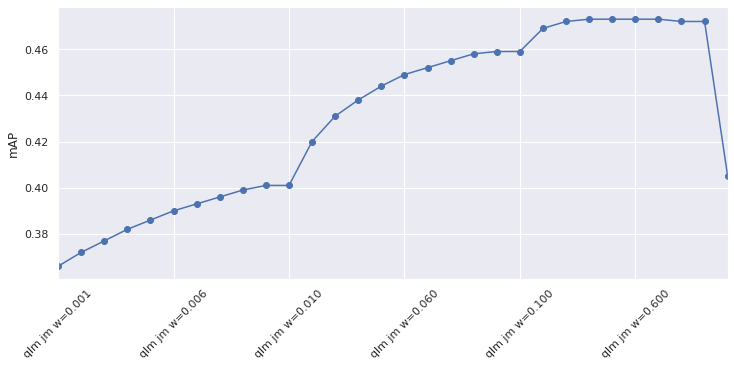

In [13]:
ax = search_jm_smoothing_results[("specific_keywords","mAP")].plot(figsize=(12,5), style="-bo", rot=45, legend=False)
ax.set_ylabel("mAP");

#### Test tf-idf models on n-grams

In [7]:
smoothing_weight_grid = create_grid([0,1,2])
search_dp_smoothing = [(f"qlm dp w={w:.2f}", QueryLMRetrievalAlgorithm("dp", w), papers_basic) for w in smoothing_weight_grid]

In [8]:
search_dp_smoothing_results = train_evaluate_models(search_dp_smoothing, [general_keywords, specific_keywords], 
                                                    n_jobs=min(15,len(smoothing_weight_grid)))

INFO:root:Start training model qlm dp w=1.00
INFO:root:Start training model qlm dp w=2.00
INFO:root:Start training model qlm dp w=3.00
INFO:root:Start training model qlm dp w=4.00
INFO:root:Start training model qlm dp w=5.00
INFO:root:Start evaluating model qlm dp w=1.00


INFO:root:Start training model qlm dp w=6.00
INFO:root:Start evaluating model qlm dp w=2.00


INFO:root:Start training model qlm dp w=7.00
INFO:root:Start evaluating model qlm dp w=3.00


INFO:root:Start training model qlm dp w=8.00
INFO:root:Start evaluating model qlm dp w=4.00


INFO:root:Start training model qlm dp w=9.00
INFO:root:Start evaluating model qlm dp w=5.00


INFO:root:Start training model qlm dp w=10.00
INFO:root:Start training model qlm dp w=20.00
INFO:root:Start evaluating model qlm dp w=6.00


INFO:root:Start evaluating model qlm dp w=7.00


INFO:root:Start training model qlm dp w=30.00
INFO:root:Start training model qlm dp w=40.00
INFO:root:Start evaluating model qlm dp w=8.00


INFO:root:Start evaluating model qlm dp w=9.00


INFO:root:Start training model qlm dp w=50.00
INFO:root:Start training model qlm dp w=60.00
INFO:root:Start evaluating model qlm dp w=10.00


INFO:root:Start evaluating model qlm dp w=20.00


INFO:root:Start evaluating model qlm dp w=30.00


INFO:root:Start evaluating model qlm dp w=40.00


INFO:root:Start evaluating model qlm dp w=50.00


INFO:root:Start evaluating model qlm dp w=60.00



INFO:root:Finished processing model qlm dp w=1.00
INFO:root:Start training model qlm dp w=70.00

INFO:root:Finished processing model qlm dp w=2.00
INFO:root:Start training model qlm dp w=80.00

INFO:root:Finished processing model qlm dp w=3.00
INFO:root:Start training model qlm dp w=90.00

INFO:root:Finished processing model qlm dp w=4.00

INFO:root:Finished processing model qlm dp w=7.00
INFO:root:Start training model qlm dp w=100.00

INFO:root:Finished processing model qlm dp w=5.00
INFO:root:Start evaluating model qlm dp w=70.00


INFO:root:Start training model qlm dp w=200.00

INFO:root:Finished processing model qlm dp w=6.00
INFO:root:Start training model qlm dp w=300.00
INFO:root:Start evaluating model qlm dp w=80.00


INFO:root:Start training model qlm dp w=400.00
INFO:root:Start evaluating model qlm dp w=90.00



INFO:root:Finished processing model qlm dp w=9.00

INFO:root:Finished processing model qlm dp w=8.00

INFO:root:Finished processing model qlm dp w=10.00
INFO:root:Start training model qlm dp w=500.00
INFO:root:Start evaluating model qlm dp w=100.00


INFO:root:Start evaluating model qlm dp w=200.00



INFO:root:Finished processing model qlm dp w=20.00
INFO:root:Start training model qlm dp w=600.00
INFO:root:Start evaluating model qlm dp w=300.00



INFO:root:Finished processing model qlm dp w=30.00
INFO:root:Start training model qlm dp w=700.00
INFO:root:Start evaluating model qlm dp w=400.00



INFO:root:Finished processing model qlm dp w=50.00
INFO:root:Start training model qlm dp w=800.00
INFO:root:Start training model qlm dp w=900.00

INFO:root:Finished processing model qlm dp w=40.00
INFO:root:Start evaluating model qlm dp w=500.00



INFO:root:Finished processing model qlm dp w=60.00
INFO:root:Start evaluating model qlm dp w=600.00


INFO:root:Start evaluating model qlm dp w=700.00


INFO:root:Start evaluating model qlm dp w=800.00


INFO:root:Start evaluating model qlm dp w=900.00



INFO:root:Finished processing model qlm dp w=70.00

INFO:root:Finished processing model qlm dp w=80.00

INFO:root:Finished processing model qlm dp w=200.00

INFO:root:Finished processing model qlm dp w=90.00

INFO:root:Finished processing model qlm dp w=100.00

INFO:root:Finished processing model qlm dp w=300.00

INFO:root:Finished processing model qlm dp w=400.00

INFO:root:Finished processing model qlm dp w=500.00

INFO:root:Finished processing model qlm dp w=600.00

INFO:root:Finished processing model qlm dp w=800.00

INFO:root:Finished processing model qlm dp w=700.00

INFO:root:Finished processing model qlm dp w=900.00


In [9]:
search_dp_smoothing_results

general keywords                                    specific_keywords                                   
                             p@5   p@10   p@20 R-prec    mAP  bpref               p@5   p@10   p@20 R-prec    mAP  bpref
qlm dp w=1.00              0.292  0.253  0.211  0.081  0.054  0.062             0.648  0.589  0.497  0.470  0.468  0.453
qlm dp w=2.00              0.293  0.253  0.211  0.081  0.054  0.062             0.648  0.590  0.497  0.471  0.468  0.454
qlm dp w=3.00              0.293  0.253  0.212  0.081  0.054  0.063             0.648  0.590  0.497  0.471  0.468  0.454
qlm dp w=4.00              0.293  0.254  0.212  0.081  0.054  0.063             0.648  0.590  0.497  0.471  0.469  0.454
qlm dp w=5.00              0.292  0.255  0.212  0.081  0.054  0.063             0.648  0.591  0.497  0.471  0.469  0.454
qlm dp w=6.00              0.291  0.255  0.213  0.082  0.054  0.063             0.648  0.591  0.498  0.471  0.469  0.454
qlm dp w=7.00              0.291  0.255  0.213  0.082  0.054  0.063             0.649  0.591  0.498  0.471  0.469  0.454
qlm dp w=8.00              0.291  0.253  0.213  0.082  0.054  0.063             0.649  0.591  0.498  0.471  0.470  0.455
qlm dp w=9.00              0.291  0.254  0.214  0.082  0.054  0.063             0.649  0.591  0.498  0.471  0.470  0.455
qlm dp w=10.00             0.291  0.253  0.214  0.082  0.054  0.063             0.649  0.591  0.499  0.471  0.470  0.455
qlm dp w=20.00             0.295  0.254  0.215  0.082  0.054  0.063             0.650  0.592  0.500  0.472  0.471  0.456
qlm dp w=30.00             0.293  0.253  0.216  0.082  0.055  0.063             0.651  0.592  0.500  0.472  0.472  0.456
qlm dp w=40.00             0.299  0.252  0.216  0.082  0.055  0.063             0.651  0.593  0.500  0.473  0.473  0.457
qlm dp w=50.00             0.301  0.253  0.216  0.083  0.055  0.064             0.652  0.593  0.501  0.473  0.473  0.457
qlm dp w=60.00             0.302  0.252  0.216  0.083  0.055  0.064             0.651  0.593  0.501  0.473  0.473  0.457
qlm dp w=70.00             0.298  0.252  0.216  0.085  0.055  0.065             0.651  0.593  0.501  0.473  0.473  0.457
qlm dp w=80.00             0.295  0.253  0.217  0.085  0.056  0.065             0.651  0.593  0.500  0.474  0.473  0.457
qlm dp w=90.00             0.297  0.252  0.216  0.085  0.056  0.065             0.649  0.593  0.500  0.473  0.473  0.457
qlm dp w=100.00            0.297  0.251  0.216  0.085  0.056  0.065             0.650  0.593  0.500  0.473  0.472  0.457
qlm dp w=200.00            0.295  0.250  0.215  0.085  0.056  0.065             0.645  0.589  0.498  0.472  0.470  0.455
qlm dp w=300.00            0.294  0.252  0.214  0.084  0.056  0.065             0.642  0.586  0.496  0.470  0.467  0.452
qlm dp w=400.00            0.294  0.251  0.213  0.084  0.056  0.065             0.640  0.584  0.495  0.468  0.465  0.450
qlm dp w=500.00            0.293  0.249  0.213  0.084  0.056  0.065             0.639  0.582  0.493  0.465  0.463  0.448
qlm dp w=600.00            0.291  0.249  0.213  0.084  0.056  0.065             0.637  0.580  0.492  0.463  0.460  0.445
qlm dp w=700.00            0.288  0.248  0.212  0.084  0.055  0.065             0.635  0.578  0.490  0.461  0.458  0.443
qlm dp w=800.00            0.288  0.249  0.212  0.084  0.055  0.065             0.634  0.577  0.488  0.459  0.456  0.441
qlm dp w=900.00            0.287  0.249  0.211  0.084  0.055  0.065             0.633  0.576  0.487  0.457  0.454  0.439

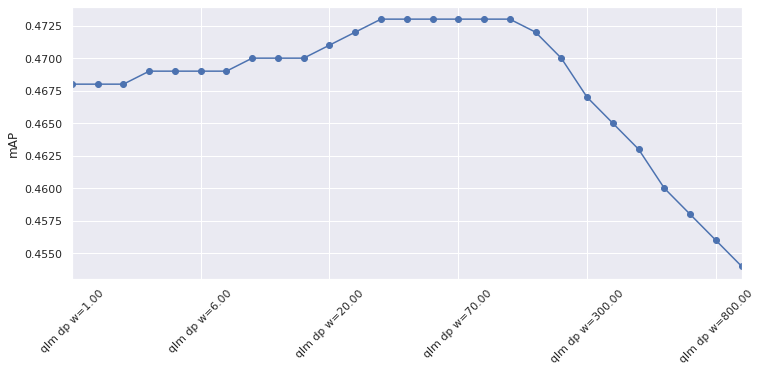

In [10]:
ax = search_dp_smoothing_results[("specific_keywords","mAP")].plot(figsize=(12,5), style="-bo", rot=45, legend=False)
ax.set_ylabel("mAP");

Results:
- No significant change for general keywords
- Bigrams provide great improvement for specific keywords
- 3 and 4-grams do not lead to significant further improvements

In [11]:
smoothing_weight_grid = np.arange(0.1,1.1,0.0)
search_jm_bigram = [(f"qlm jm w={w:.2f}", QueryLMRetrievalAlgorithm("jm", w, max_ngram=2), papers_basic_lemmatization_nouns) for w in smoothing_weight_grid]

In [ ]:
search_jm_bigram_results = train_evaluate_models(search_jm_bigram, [general_keywords, specific_keywords], n_jobs=len(smoothing_weight_grid))

In [31]:
search_jm_bigram_results

NameError: name 'search_jm_bigram_results' is not defined

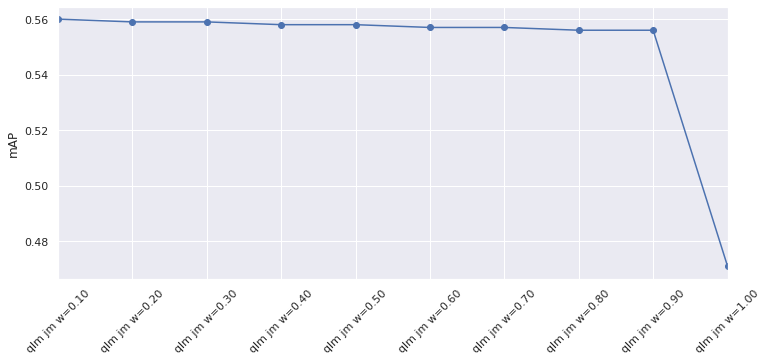

In [14]:
ax = search_jm_bigram_results[("specific_keywords","mAP")].plot(figsize=(12,5), style="-bo", rot=45, legend=False)
ax.set_ylabel("mAP");

In [15]:
smoothing_weight_grid = create_grid([0,1,2])
search_dp_bigram = [(f"qlm jm w={w:.2f}", QueryLMRetrievalAlgorithm("dp", w, max_ngram=2), papers_basic_lemmatization_nouns) for w in smoothing_weight_grid]

In [ ]:
search_dp_bigram_results = train_evaluate_models(search_dp_bigram, [general_keywords, specific_keywords], 
                                                 n_jobs=min(15,len(smoothing_weight_grid)))

In [18]:
search_dp_bigram_results

general keywords                                    specific_keywords                                   
                             p@5   p@10   p@20 R-prec    mAP  bpref               p@5   p@10   p@20 R-prec    mAP  bpref
qlm jm w=1.00              0.306  0.258  0.213  0.084  0.056  0.065             0.727  0.668  0.561  0.543  0.549  0.537
qlm jm w=2.00              0.306  0.258  0.214  0.084  0.056  0.065             0.727  0.669  0.562  0.543  0.550  0.537
qlm jm w=3.00              0.306  0.259  0.213  0.084  0.056  0.065             0.728  0.669  0.562  0.543  0.550  0.537
qlm jm w=4.00              0.306  0.259  0.213  0.084  0.056  0.065             0.728  0.669  0.562  0.544  0.550  0.538
qlm jm w=5.00              0.306  0.260  0.213  0.084  0.056  0.065             0.728  0.669  0.562  0.544  0.550  0.538
qlm jm w=6.00              0.307  0.259  0.213  0.084  0.056  0.065             0.728  0.669  0.562  0.544  0.550  0.538
qlm jm w=7.00              0.306  0.259  0.213  0.084  0.056  0.065             0.728  0.669  0.562  0.544  0.550  0.538
qlm jm w=8.00              0.305  0.258  0.213  0.084  0.057  0.065             0.729  0.669  0.562  0.544  0.551  0.538
qlm jm w=9.00              0.305  0.259  0.213  0.084  0.057  0.065             0.729  0.669  0.562  0.544  0.551  0.538
qlm jm w=10.00             0.305  0.259  0.214  0.084  0.057  0.065             0.729  0.670  0.562  0.544  0.551  0.538
qlm jm w=20.00             0.305  0.258  0.214  0.085  0.057  0.065             0.730  0.670  0.563  0.545  0.552  0.539
qlm jm w=30.00             0.305  0.259  0.216  0.085  0.057  0.066             0.730  0.670  0.563  0.545  0.553  0.540
qlm jm w=40.00             0.307  0.260  0.216  0.086  0.057  0.066             0.730  0.670  0.564  0.546  0.553  0.540
qlm jm w=50.00             0.308  0.262  0.217  0.086  0.057  0.066             0.729  0.671  0.564  0.546  0.554  0.540
qlm jm w=60.00             0.308  0.263  0.219  0.086  0.057  0.066             0.729  0.670  0.564  0.546  0.554  0.541
qlm jm w=70.00             0.311  0.263  0.219  0.087  0.058  0.066             0.728  0.670  0.564  0.546  0.555  0.541
qlm jm w=80.00             0.313  0.263  0.218  0.087  0.058  0.067             0.729  0.670  0.564  0.546  0.555  0.541
qlm jm w=90.00             0.311  0.264  0.218  0.087  0.058  0.067             0.730  0.670  0.564  0.546  0.555  0.541
qlm jm w=100.00            0.312  0.264  0.218  0.087  0.058  0.067             0.729  0.670  0.564  0.546  0.555  0.541
qlm jm w=200.00            0.316  0.262  0.219  0.088  0.059  0.068             0.728  0.669  0.563  0.546  0.556  0.541
qlm jm w=300.00            0.311  0.263  0.218  0.088  0.059  0.068             0.726  0.668  0.563  0.546  0.555  0.541
qlm jm w=400.00            0.310  0.263  0.218  0.088  0.059  0.068             0.726  0.667  0.562  0.546  0.555  0.540
qlm jm w=500.00            0.307  0.262  0.217  0.090  0.059  0.069             0.724  0.666  0.562  0.545  0.555  0.540
qlm jm w=600.00            0.306  0.262  0.216  0.090  0.059  0.069             0.723  0.665  0.562  0.545  0.554  0.540
qlm jm w=700.00            0.303  0.262  0.217  0.091  0.059  0.069             0.723  0.665  0.562  0.545  0.554  0.539
qlm jm w=800.00            0.302  0.263  0.217  0.091  0.059  0.069             0.722  0.664  0.562  0.545  0.554  0.539
qlm jm w=900.00            0.301  0.263  0.217  0.091  0.059  0.069             0.722  0.664  0.562  0.545  0.554  0.539

#### Export best model

In [ ]:
best_tfidf_model = TfIdfRetrievalAlgorithm(max_ngram=2, use_idf=True, sublinear_tf=True, min_df=2)
best_tfidf_model.prepare(papers_basic_lemmatization_nouns)

In [ ]:
file_path = "../data/models/tfidf/tfidf_lemmatized_bigram.model"
with open(file_path, "wb") as file:
    pickle.dump(best_tfidf_model, file)